In [1]:
import torch
from torch_geometric.nn import GCNConv, GINConv, GraphConv
from torch_geometric.utils import train_test_split_edges
from itertools import combinations
import time
from torch.nn import Embedding, Sequential, Linear, ModuleList, ReLU
import argparse
import os, sys
import pickle as pkl
from tqdm import tqdm
from ogb.graphproppred import PygGraphPropPredDataset
from torch.autograd import Variable
from torch_geometric.data import Data, DataLoader
from networkx.algorithms.components import strongly_connected_components
import numpy as np
import os.path as osp
from sklearn.metrics import f1_score
from torch_geometric.data import Batch
from torch_geometric.datasets import PPI
from torch_geometric.loader import ClusterData, ClusterLoader, DataLoader
from torch_geometric.nn import BatchNorm, SAGEConv
import os.path as osp
from sklearn.metrics import f1_score
import pandas as pd
from torch_geometric.data import Batch
from torch_geometric.datasets import TUDataset, MoleculeNet, GEDDataset
from utils.GNNBenchmarkDataset import GNNBenchmarkDataset
from utils.UPFD import UPFD
from torch_geometric.loader import ClusterData, ClusterLoader, DataLoader, ShaDowKHopSampler
from torch_geometric.nn import BatchNorm, SAGEConv
from torch_geometric.utils import contains_isolated_nodes
from torch_sparse import SparseTensor, cat
from torch_scatter import scatter
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from models.model import *
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
class Args:
    def __init__(self):
        self.data_dir = '../../data'
        self.save_dir = '../../data/processed'
        self.write_dir = '.results/processed'
        self.dataset = 'MUTAG'
        self.idx = 1
        self.gpu = 0
        self.num_clusters = 5
        self.hidden_dim = 64
        self.number_layers = 2
        self.lr = 5e-4
        
args = Args()

dataset_name = args.dataset
DATA_PATH = args.data_dir
idx = args.idx

if dataset_name in ['DD', 'MUTAG', 'PROTEINS', 'IMDB-BINARY', 'IMDB-MULTI', 'REDDIT-BINARY', 'COLLAB']:
    path = osp.join(DATA_PATH, 'TUDataset')
    dataset = TUDataset(path, name=dataset_name)
    num_splits = 10
elif dataset_name in ['brain']:
    path = osp.join(DATA_PATH, 'brain')
    with open(os.path.join(path, 'sc.pkl'), 'rb') as f:
        dataset = pkl.load(f)
    num_splits = 10
elif dataset_name in ['UPFD']:
    path = osp.join(DATA_PATH, 'UPFD')
    dataset_train = UPFD(path, feature='content', name='politifact', split='train')
    dataset_val = UPFD(path, feature='content', name='politifact', split='val')
    dataset_test = UPFD(path, feature='content', name='politifact', split='test')
elif dataset_name in ['MNIST', 'CIFAR10']:
    path = osp.join(DATA_PATH, 'GNNBenchmarkDataset')
    dataset_train = GNNBenchmarkDataset(path, name=dataset_name, split='train')
    dataset_val = GNNBenchmarkDataset(path, name=dataset_name, split='val')
    dataset_test = GNNBenchmarkDataset(path, name=dataset_name, split='test')
elif dataset_name in ['hiv', 'bace', 'bbbp']:
    path = osp.join(DATA_PATH, 'PygGraphPropPredDataset')
    dataset = PygGraphPropPredDataset(name = 'ogbg-mol'+dataset_name, root = path)   
    split_indices = dataset.get_idx_split() 
    train_indices = split_indices["train"]
    val_indices = split_indices["valid"]
    test_indices = split_indices["test"]
    dataset_train = dataset[train_indices]
    dataset_val = dataset[val_indices]
    dataset_test = dataset[test_indices]
if idx>1 and not dataset_name in ['DD', 'MUTAG', 'PROTEINS', 'IMDB-BINARY', 'IMDB-MULTI','COLLAB', 'brain', 'REDDIT-BINARY']:
    raise ValueError(dataset_name + 'does not have 10-fold validation.')
    exit()

if dataset_name in ['MNIST', 'CIFAR10', 'hiv', 'bace', 'bbbp', 'UPFD']:

    path = osp.join(args.save_dir, dataset_name)

    assert os.path.exists(path)

    with open(osp.join(path, 'batched_data_cluster'+str(args.num_clusters)+'.pkl'), 'rb') as f:
        store_dataset = pkl.load(f)

    batched_dataset_train_node = store_dataset['batched_dataset_train_node']
    batched_dataset_train_edge = store_dataset['batched_dataset_train_edge']
    clustered_edge_index_train = store_dataset['clustered_edge_index_train']
    clustered_batch_train = store_dataset['clustered_batch_train']
    y_true_train = store_dataset['y_true_train']
    batched_dataset_val_node = store_dataset['batched_dataset_val_node']
    batched_dataset_val_edge = store_dataset['batched_dataset_val_edge']
    clustered_edge_index_val = store_dataset['clustered_edge_index_val']
    clustered_batch_val = store_dataset['clustered_batch_val']
    y_true_val = store_dataset['y_true_val']
    batched_dataset_test_node = store_dataset['batched_dataset_test_node']
    batched_dataset_test_edge = store_dataset['batched_dataset_test_edge']
    clustered_edge_index_test = store_dataset['clustered_edge_index_test']
    clustered_batch_test = store_dataset['clustered_batch_test']
    y_true_test = store_dataset['y_true_test']
elif dataset_name in ['DD', 'MUTAG', 'PROTEINS', 'IMDB-BINARY', 'IMDB-MULTI','COLLAB', 'brain', 'REDDIT-BINARY']:
    i = idx
    path = osp.join(args.save_dir, dataset_name)
    with open(osp.join(path, 'batched_data_'+str(i)+'_cluster'+str(args.num_clusters)+'.pkl'), 'rb') as f:
        store_dataset = pkl.load(f)

    batched_dataset_train_node = store_dataset['batched_dataset_train_node']
    batched_dataset_train_edge = store_dataset['batched_dataset_train_edge']
    clustered_edge_index_train = store_dataset['clustered_edge_index_train']
    clustered_batch_train = store_dataset['clustered_batch_train']
    y_true_train = store_dataset['y_true_train']
    batched_dataset_test_node = store_dataset['batched_dataset_test_node']
    batched_dataset_test_edge = store_dataset['batched_dataset_test_edge']
    clustered_edge_index_test = store_dataset['clustered_edge_index_test']
    clustered_batch_test = store_dataset['clustered_batch_test']
    y_true_test = store_dataset['y_true_test']



In [3]:
dataset

MUTAG(188)

In [4]:
batched_dataset = DataLoader(dataset, batch_size=len(dataset))

In [5]:
for data in batched_dataset:
    pass

In [6]:
from torch_geometric.nn import WLConv
wlconv = WLConv()

In [7]:
hashed_x_first = wlconv(
    torch.ones((data.num_nodes), dtype=torch.long), 
    data.edge_index
)
hashed_x_second = wlconv(
    hashed_x_first, 
    data.edge_index
)
hist = wlconv.histogram(hashed_x_second, data.batch)

In [8]:
coarse_num_nodes = int(torch.max(clustered_edge_index_train[0])+1)
coarse_hashed_x_first = wlconv(
    torch.ones((coarse_num_nodes), dtype=torch.long), 
    clustered_edge_index_train[0]
)
coarse_hashed_x_second = wlconv(
    coarse_hashed_x_first, 
    clustered_edge_index_train[0]
)
coarse_hist = wlconv.histogram(coarse_hashed_x_second, clustered_batch_train[0])

In [9]:
fine_hist_normalized = hist.sum(axis=0)
coarse_hist_normalized = coarse_hist.sum(axis=0)
fine_hist_normalized = fine_hist_normalized / fine_hist_normalized.sum()
coarse_hist_normalized = coarse_hist_normalized / coarse_hist_normalized.sum()

In [10]:
fine_hist_normalized_np = fine_hist_normalized.numpy()
coarse_hist_normalized_np = coarse_hist_normalized.numpy()
longlength = max(len(fine_hist_normalized_np), len(coarse_hist_normalized_np))

In [11]:
fine_hist_normalized_np = np.concatenate([fine_hist_normalized_np, np.zeros(longlength - len(fine_hist_normalized_np))])
coarse_hist_normalized_np = np.concatenate([coarse_hist_normalized_np, np.zeros(longlength - len(coarse_hist_normalized_np))])

In [12]:
np.corrcoef(fine_hist_normalized_np, coarse_hist_normalized_np)

array([[1.        , 0.66778588],
       [0.66778588, 1.        ]])

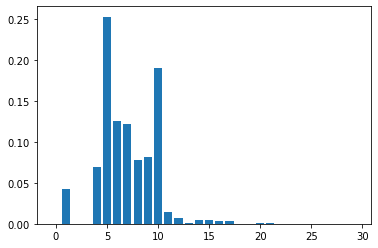

<BarContainer object of 30 artists>

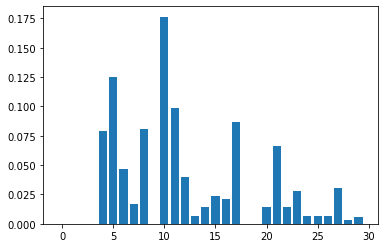

In [13]:
plt.bar(np.arange(len(fine_hist_normalized_np)), fine_hist_normalized_np)
plt.show()
plt.bar(np.arange(len(coarse_hist_normalized_np)), coarse_hist_normalized_np)

In [16]:
simCoef = np.corrcoef(fine_hist_normalized_np, coarse_hist_normalized_np)[0,1]

In [15]:
test_accuracy_list_all = []
hidden_channels = args.hidden_dim
if dataset_name in ['brain']:
    in_channels_nodes = 3
    in_channels_edges = 1
    num_classes = 8
else:
    try:
        in_channels_nodes = dataset.num_node_features
        in_channels_edges = dataset.num_edge_features
        num_classes = dataset.num_classes
    except:
        in_channels_nodes = dataset_train.num_node_features
        in_channels_edges = dataset_train.num_edge_features
        num_classes = dataset_train.num_classes

if dataset_name in ['MNIST', 'CIFAR10']:
    in_channels_nodes += 2
if in_channels_nodes == 0:
    nodes_feature_flag = False
    in_channels_nodes = 1
else:
    nodes_feature_flag = True

if in_channels_edges == 0:
    edge_feature_flag = False
    in_channels_edges = 1
else:
    edge_feature_flag = True



In [ ]:
class ClusterModel(torch.nn.Module):
    def __init__(self, in_channels_nodes, in_channels_edges, hidden_channels, num_classes, num_layers, edge_feature_flag):
        super().__init__()
        if edge_feature_flag:
            self.net1 = GINENet(in_channels_nodes, in_channels_edges, hidden_channels, hidden_channels, num_layers)
        else:
            self.net1 = GINNet(in_channels_nodes, hidden_channels, hidden_channels, num_layers)
            
        self.net2 = GINENet(hidden_channels, hidden_channels, hidden_channels, num_classes, num_layers)
        self.edge_feature_flag = edge_feature_flag
        
    def forward(self, 
                x_node, edge_index_node, edge_attr_node, batch_node,
                x_edge, edge_index_edge, edge_attr_edge, batch_edge,
                edge_index_cluster, batch_cluster):
        if self.edge_feature_flag:
            # with edge feature
            edge_attr_cluster = self.net1(x_edge, edge_index_edge, edge_attr_edge, batch_edge)
            x_cluster = self.net1(x_node, edge_index_node, edge_attr_node, batch_node)
        else: 
            # no edge feature
            edge_attr_cluster = self.net1(x_edge, edge_index_edge, batch_edge)
            x_cluster = self.net1(x_node, edge_index_node, batch_node)
            
        out = self.net2(x_cluster, edge_index_cluster, edge_attr_cluster, batch_cluster)
        return out

In [17]:
model = ClusterModel(
    in_channels_nodes=in_channels_nodes, 
    in_channels_edges=in_channels_edges, 
    hidden_channels=hidden_channels, 
    num_classes=num_classes, 
    num_layers=args.number_layers,
    edge_feature_flag=edge_feature_flag,
)

In [18]:
model

ClusterModel(
  (net1): GINENet(
    (lin_init_node): MLP(
      (mlp): ModuleList(
        (0): Linear(9, 64, bias=True)
        (1): Linear(64, 64, bias=True)
      )
    )
    (lin_init_edge): MLP(
      (mlp): ModuleList(
        (0): Linear(3, 64, bias=True)
        (1): Linear(64, 64, bias=True)
      )
    )
    (convs): ModuleList(
      (0): GINEConv(nn=MLP(
        (mlp): ModuleList(
          (0): Linear(64, 64, bias=True)
          (1): Linear(64, 64, bias=True)
        )
      ))
      (1): GINEConv(nn=MLP(
        (mlp): ModuleList(
          (0): Linear(64, 64, bias=True)
          (1): Linear(64, 64, bias=True)
        )
      ))
    )
    (batch_norms): ModuleList(
      (0): BatchNorm(64)
    )
  )
  (net2): GINENet(
    (lin_init_node): MLP(
      (mlp): ModuleList(
        (0): Linear(64, 64, bias=True)
        (1): Linear(64, 64, bias=True)
      )
    )
    (lin_init_edge): MLP(
      (mlp): ModuleList(
        (0): Linear(64, 64, bias=True)
        (1): Linear(64

In [14]:


#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:'+str(args.gpu))
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()#torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

def train(batched_dataset_node, batched_dataset_edge, batched_clustered_edge_index, batched_clustered_batch, batched_y_true):
    loss_value_list = []
    model.train()
    for data_node, data_edge, clustered_edge_index, clustered_batch, y_true in zip(batched_dataset_node, batched_dataset_edge, batched_clustered_edge_index, batched_clustered_batch, batched_y_true):
        edge_index_node, batch_node = data_node.edge_index, data_node.batch
        edge_index_edge, batch_edge = data_edge.edge_index, data_edge.batch
        if nodes_feature_flag:
            x_node = data_node.x.float()
            x_edge = data_edge.x.float()
        else:
            x_node = torch.zeros((data_node.num_nodes, 1))
            x_edge = torch.zeros((data_edge.num_nodes, 1))
        if edge_feature_flag:
            edge_attr_node = data_node.edge_attr.float()
            edge_attr_edge = data_edge.edge_attr.float()
        else:
            edge_attr_node = torch.zeros((data_node.num_edges, 1))
            edge_attr_edge = torch.zeros((data_edge.num_edges, 1))

        x_node, edge_index_node, edge_attr_node, batch_node = x_node.to(device), edge_index_node.to(device), edge_attr_node.to(device), batch_node.to(device)
        x_edge, edge_index_edge, edge_attr_edge, batch_edge = x_edge.to(device), edge_index_edge.to(device), edge_attr_edge.to(device), batch_edge.to(device) 

        if len(edge_attr_node.shape) == 1:
            edge_attr_node = edge_attr_node.view(-1,1)
            edge_attr_edge = edge_attr_edge.view(-1,1)
        if dataset_name in ['MNIST', 'CIFAR10']:
            pos_node = data_node.pos.float().to(device)
            x_node = torch.cat([x_node, pos_node], dim=-1)
            pos_edge = data_edge.pos.float().to(device)
            x_edge = torch.cat([x_edge, pos_edge], dim=-1)
        clustered_edge_index, clustered_batch = clustered_edge_index.to(device), clustered_batch.to(device)
        y_true = y_true.view(-1).to(device)

        out = model(
            x_node, edge_index_node, edge_attr_node, batch_node,
            x_edge, edge_index_edge, edge_attr_edge, batch_edge,
            clustered_edge_index, clustered_batch
        )
        loss = criterion(out, y_true)  # Compute the loss.
        loss_value = float(loss)
        loss_value_list.append(loss_value)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss_value_list

def test(batched_dataset_node, batched_dataset_edge, batched_clustered_edge_index, batched_clustered_batch, batched_y_true):
    y_pred_list = []
    model.eval()
    for data_node, data_edge, clustered_edge_index, clustered_batch, y_true in zip(batched_dataset_node, batched_dataset_edge, batched_clustered_edge_index, batched_clustered_batch, batched_y_true):
        edge_index_node, batch_node = data_node.edge_index, data_node.batch
        edge_index_edge, batch_edge = data_edge.edge_index, data_edge.batch
        if nodes_feature_flag:
            x_node = data_node.x.float()
            x_edge = data_edge.x.float()
        else:
            x_node = torch.zeros((data_node.num_nodes, 1))
            x_edge = torch.zeros((data_edge.num_nodes, 1))
        if edge_feature_flag:
            edge_attr_node = data_node.edge_attr.float()
            edge_attr_edge = data_edge.edge_attr.float()
        else:
            edge_attr_node = torch.zeros((data_node.num_edges, 1))
            edge_attr_edge = torch.zeros((data_edge.num_edges, 1))

        x_node, edge_index_node, edge_attr_node, batch_node = x_node.to(device), edge_index_node.to(device), edge_attr_node.to(device), batch_node.to(device)
        x_edge, edge_index_edge, edge_attr_edge, batch_edge = x_edge.to(device), edge_index_edge.to(device), edge_attr_edge.to(device), batch_edge.to(device) 

        if len(edge_attr_node.shape) == 1:
            edge_attr_node = edge_attr_node.view(-1,1)
            edge_attr_edge = edge_attr_edge.view(-1,1)
        if dataset_name in ['MNIST', 'CIFAR10']:
            pos_node = data_node.pos.float().to(device)
            x_node = torch.cat([x_node, pos_node], dim=-1)
            pos_edge = data_edge.pos.float().to(device)
            x_edge = torch.cat([x_edge, pos_edge], dim=-1)
        clustered_edge_index, clustered_batch = clustered_edge_index.to(device), clustered_batch.to(device)
        out = model(
            x_node, edge_index_node, edge_attr_node, batch_node,
            x_edge, edge_index_edge, edge_attr_edge, batch_edge,
            clustered_edge_index, clustered_batch
        )
        #pred = out.argmax(dim=1)  # Use the class with highest probability.
        #y_pred_list.append(pred.detach().cpu())
        out = out.softmax(dim=1)
        y_pred_list.append(out.detach().cpu())

    y_pred = torch.cat(y_pred_list)
    return y_pred 



In [16]:
start_time = time.time()
test_accuracy_list = []

directory = os.path.join(args.write_dir, args.dataset, str(args.num_clusters), str(args.idx), str(args.hidden_dim)+'_'+str(args.number_layers)+'_'+str(args.lr))
print(args.dataset, str(args.num_clusters), str(args.idx), str(args.hidden_dim), str(args.number_layers), str(args.lr))
if not os.path.exists(directory):
    os.makedirs(directory)

f = open(os.path.join(directory, 'log.txt'), 'a')
if dataset_name in ['hiv', 'bace', 'bbbp', 'UPFD']:
    print('Epoch, Loss, Train rocauc, Val rocauc, Test rocauc, Time')
elif dataset_name in ['MNIST', 'CIFAR10']:
    print('Epoch, Loss, Train Accuracy, Val Accuracy, Test Accuracy, Time')
else:
    print('Epoch, Loss, Train Accuracy, Test Accuracy, Time')

results = []
for epoch in (range(200)):
    loss_value_list = train(batched_dataset_train_node, batched_dataset_train_edge, clustered_edge_index_train, clustered_batch_train, y_true_train)
    y_pred_train = test(batched_dataset_train_node, batched_dataset_train_edge, clustered_edge_index_train, clustered_batch_train, y_true_train)
    y_pred_test = test(batched_dataset_test_node, batched_dataset_test_edge, clustered_edge_index_test, clustered_batch_test, y_true_test)

    loss_value = np.mean(loss_value_list)

    # reshape y_true
    y_true_train_1d = torch.cat(y_true_train).view(-1).numpy()
    y_true_test_1d = torch.cat(y_true_test).view(-1).numpy()
    y_true_train_2d = np.zeros((y_true_train_1d.size, y_true_train_1d.max()+1))
    y_true_train_2d[np.arange(y_true_train_1d.size),y_true_train_1d] = 1
    y_true_test_2d = np.zeros((y_true_test_1d.size, y_true_test_1d.max()+1))
    y_true_test_2d[np.arange(y_true_test_1d.size),y_true_test_1d] = 1

    if dataset_name in ['MNIST', 'CIFAR10', 'hiv', 'bace', 'bbbp', 'UPFD']:
        y_pred_val = test(batched_dataset_val_node, batched_dataset_val_edge, clustered_edge_index_val, clustered_batch_val, y_true_val)
        y_true_val_1d = torch.cat(y_true_val).view(-1).numpy()
        y_true_val_2d = np.zeros((y_true_val_1d.size, y_true_val_1d.max()+1))
        y_true_val_2d[np.arange(y_true_val_1d.size),y_true_val_1d] = 1

    if dataset_name in ['hiv', 'bace', 'bbbp', 'UPFD']:
        train_accuracy = roc_auc_score(y_true_train_2d, y_pred_train.numpy())
        val_accuracy = roc_auc_score(y_true_val_2d, y_pred_val.numpy())
        test_accuracy = roc_auc_score(y_true_test_2d, y_pred_test.numpy())
        results.append([epoch, loss_value, train_accuracy, val_accuracy, test_accuracy, time.time()-start_time])
        print("{:03d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(epoch, loss_value, train_accuracy, val_accuracy, test_accuracy, time.time()-start_time))
    elif dataset_name in ['MNIST', 'CIFAR10']:
        y_pred_train, y_pred_val, y_pred_test = y_pred_train.argmax(dim=1), y_pred_val.argmax(dim=1), y_pred_test.argmax(dim=1)
        train_accuracy = accuracy_score(y_true_train_1d, y_pred_train.numpy())
        val_accuracy = accuracy_score(y_true_val_1d, y_pred_val.numpy())
        test_accuracy = accuracy_score(y_true_test_1d, y_pred_test.numpy())
        results.append([epoch, loss_value, train_accuracy, val_accuracy, test_accuracy, time.time()-start_time])
        print("{:03d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(epoch, loss_value, train_accuracy, val_accuracy, test_accuracy, time.time()-start_time))
    else:
        y_pred_train, y_pred_test = y_pred_train.argmax(dim=1), y_pred_test.argmax(dim=1)
        train_accuracy = accuracy_score(y_true_train_1d, y_pred_train.numpy())
        test_accuracy = accuracy_score(y_true_test_1d, y_pred_test.numpy())
        results.append([epoch, loss_value, train_accuracy, test_accuracy, time.time()-start_time])
        print("{:03d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(epoch, loss_value, train_accuracy, test_accuracy, time.time()-start_time))

if dataset_name in ['hiv', 'bace', 'bbbp', 'UPFD']:
    df = pd.DataFrame(data=results, columns=['Epoch', 'Loss', 'Train rocauc', 'Val rocauc', 'Test rocauc', 'Time'])
elif dataset_name in ['MNIST', 'CIFAR10']:
    df = pd.DataFrame(data=results, columns=['Epoch', 'Loss', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy', 'Time'])
else:
    df = pd.DataFrame(data=results, columns=['Epoch', 'Loss', 'Train Accuracy', 'Test Accuracy', 'Time'])

#df.to_csv(os.path.join(directory, 'results.csv'), index=False)




bace 5 1 64 2 0.0005
Epoch, Loss, Train rocauc, Val rocauc, Test rocauc, Time
000, 0.6907, 0.6520, 0.6886, 0.7602, 0.1841
001, 0.6726, 0.6581, 0.6890, 0.7628, 0.3722
002, 0.6676, 0.6621, 0.6941, 0.7625, 0.5363
003, 0.6679, 0.6648, 0.7051, 0.7649, 0.7008
004, 0.6715, 0.6692, 0.6967, 0.7675, 0.8606
005, 0.6687, 0.6732, 0.7088, 0.7679, 1.0468
006, 0.6727, 0.6741, 0.6978, 0.7672, 1.2469
007, 0.6676, 0.6805, 0.7095, 0.7715, 1.4462
008, 0.6701, 0.6786, 0.7103, 0.7734, 1.6238
009, 0.6651, 0.6765, 0.7018, 0.7722, 1.8117
010, 0.6629, 0.6827, 0.7022, 0.7746, 2.0111
011, 0.6658, 0.6819, 0.7059, 0.7729, 2.1752
012, 0.6663, 0.6826, 0.7048, 0.7734, 2.3439
013, 0.6623, 0.6829, 0.7110, 0.7783, 2.5047
014, 0.6634, 0.6819, 0.7048, 0.7769, 2.6653
015, 0.6611, 0.6866, 0.7029, 0.7823, 2.8523
016, 0.6625, 0.6878, 0.6971, 0.7795, 3.0147
017, 0.6579, 0.6920, 0.6967, 0.7849, 3.1775
018, 0.6613, 0.6934, 0.7040, 0.7820, 3.3399
019, 0.6568, 0.6938, 0.6974, 0.7879, 3.5079
020, 0.6589, 0.6953, 0.6989, 0.7893, 3.668

182, 0.5574, 0.8312, 0.6729, 0.7482, 29.8664
183, 0.5056, 0.8206, 0.6879, 0.7531, 30.0216
184, 0.5638, 0.8310, 0.6850, 0.7427, 30.1781
185, 0.5059, 0.8225, 0.6795, 0.7560, 30.3294
186, 0.5540, 0.8362, 0.6667, 0.7447, 30.4819
187, 0.4995, 0.8228, 0.6861, 0.7409, 30.6228
188, 0.5624, 0.8305, 0.6341, 0.7461, 30.7645
189, 0.5170, 0.8171, 0.6853, 0.7508, 30.9059
190, 0.5555, 0.8316, 0.6502, 0.7454, 31.0472
191, 0.5478, 0.8057, 0.7011, 0.7390, 31.1880
192, 0.5535, 0.8224, 0.6150, 0.7388, 31.3290
193, 0.5399, 0.8211, 0.6978, 0.7613, 31.4697
194, 0.5265, 0.8367, 0.6480, 0.7395, 31.6111
195, 0.4999, 0.8334, 0.6846, 0.7574, 31.7514
196, 0.5486, 0.8378, 0.6260, 0.7385, 31.8918
197, 0.4943, 0.8249, 0.6883, 0.7519, 32.0318
198, 0.5722, 0.8279, 0.5923, 0.7291, 32.1722
199, 0.5203, 0.8269, 0.6978, 0.7541, 32.3125
